# Electrolyzer Data Exploratoy Data analysis

In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
    
# Set a random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.layers import Input, Conv1D, Flatten, Dense, LSTM
from keras.models import Model
from keras.models import clone_and_build_model
from keras.callbacks import EarlyStopping

# Helper Functions 

In [2]:
def sliding_window(data, window_size, stride):
    """
    Extracts sliding window segments from time-series data for each class label.

    Parameters:
    - data (DataFrame): Input time-series data with columns representing features and a 'Fault_class' column for labels.
    - window_size (int): Size of the sliding window.
    - stride (int): Number of data points to move the sliding window at each step.

    Returns:
    - R (array): Array of sliding window segments.
    - Y (array): Array of corresponding labels for each segment.
    - pseudo_label (array): Array of incidence vector (C) for each segment.
    """
    
    # Initialize variables to store the segments and labels
    
    residuals = []
    labels = []
    C = []
    
    # Iterate over each class label in the data
    for label in data['Fault_class'].unique():
        # Get the data for the current class label
        class_data = data[data['Fault_class'] == label].iloc[30:]
    
        # Iterate over the data
        for i in range(0, len(class_data) - window_size, stride):
            # Get the current segment and label
            
            residual = class_data.iloc[i:i+window_size,1:7]
            
            label = class_data.iloc[i+window_size][-1]

            c = class_data.iloc[i+window_size,7:-1]
        
            # Add the segment and label to the list
            residuals.append(residual)
            labels.append(label)
            C.append(c)
    
    R,Y,pseudo_label= np.array(residuals),  np.array(labels), np.array(C)

    
    # Return the segments and labels
    return R,Y,pseudo_label

def DeepLearningModel(InputFeature, Target, last_layer_activation, loss_fn):
    """
    Create a deep learning model using Convolutional Neural Network (CNN) architecture.

    Parameters:
    - InputFeature (numpy.ndarray): Input features with shape (batch_size, sequence_length, feature_dim).
    - Target (numpy.ndarray): Target values with shape (batch_size, num_classes).
    - last_layer_activation (str): Activation function for the output layer. Common choices: 'sigmoid' for binary classification, 'softmax' for multi-class classification.
    - loss_fn (str): Loss function to optimize during training. Common choices: 'binary_crossentropy' for binary classification, 'categorical_crossentropy' for multi-class classification.

    Returns:
    - nn_model (tensorflow.keras.models.Model): Compiled Keras model for deep learning.

    Example:
    ```python
    # Example usage:
    model = DeepLearningModel(InputFeature, Target, 'sigmoid', 'binary_crossentropy')
    ```
    """
    # Define input layer
    input_layer = Input(shape=(InputFeature.shape[1], InputFeature.shape[2]))

    # Define CNN layers with batch normalization in between
    cnn1 = Conv1D(32, 3, padding='same', activation='relu')(input_layer)
    cnn1 = Conv1D(32, 3, padding='same', activation='relu')(cnn1)
    cnn1 = Flatten()(cnn1)

    # Define hidden layer with batch normalization
    hidden_layer = Dense(units=64, activation='relu')(cnn1)

    # Define output layer with specified activation function
    outputs = Dense(Target.shape[1], activation=last_layer_activation)(hidden_layer)

    # Define the model
    nn_model = Model(inputs=input_layer, outputs=outputs)

    # Compile the model with specified loss function and Adam optimizer
    nn_model.compile(loss=loss_fn, optimizer='adam', metrics=['binary_accuracy'])

    return nn_model

def Resample(X_sc, Y, Z, num_samples):
    """
    Resample the input data to balance the class distribution.

    Parameters:
    - X_sc (numpy.ndarray): Input data array. If 2D, it represents features; if 3D, it represents features over time steps.
    - Y (numpy.ndarray): Array of labels corresponding to each data point in X_sc.
    - Z (numpy.ndarray): Additional information array with the same number of features as X_sc.
    - num_samples (int): Number of samples to be resampled for each unique class label.

    Returns:
    - tuple: A tuple containing resampled data arrays (x_sample, y_sample, z_sample).
      - x_sample (numpy.ndarray): Resampled input data array.
      - y_sample (numpy.ndarray): Resampled array of labels.
      - z_sample (numpy.ndarray): Resampled additional information array.

    Notes:
    - The function uses sklearn.utils.resample to resample data for each unique class label.
    - Assumes Z has the same number of features as X_sc.

    Example:
    >>> X_resampled, Y_resampled, Z_resampled = resample(X_train, Y_train, Z_train, num_samples=1000)
    """
    # Check if the input data is 2D or 3D
    if len(X_sc.shape) == 3:
        num_features = X_sc.shape[1]
        num_time_steps = X_sc.shape[2]
        x_sample = np.zeros((num_samples * np.unique(Y).size, num_features, num_time_steps))
    else:
        num_features = X_sc.shape[1]
        x_sample = np.zeros((num_samples * np.unique(Y).size, num_features))
    y_sample = np.zeros(num_samples * np.unique(Y).size)
    z_sample = np.zeros((num_samples * np.unique(Y).size, Z.shape[1]))  # Assuming Z has the same number of features as X

    for i, label in enumerate(np.unique(Y)):
        class_indices = np.where(Y == label)[0]
        sampled_indices = resample(class_indices, n_samples=num_samples, replace=False, random_state=0)
        x_sample[i*num_samples:(i+1)*num_samples] = X_sc[sampled_indices]
        y_sample[i*num_samples:(i+1)*num_samples] = Y[sampled_indices]
        z_sample[i*num_samples:(i+1)*num_samples] = Z[sampled_indices]

    return x_sample, y_sample, z_sample


def FineTunedModel(nn_model,x_train,y_train,X_sc,Y_ohe):
    """
    Fine-tunes a neural network model by adding and training additional layers on top of
    the intermediate layer of the provided base model.

    Parameters:
    - nn_model (tf.keras.Model): The base neural network model to be fine-tuned.
    - x_train (numpy.ndarray): The input training data.
    - y_train (numpy.ndarray): The target training data.
    - X_sc (numpy.ndarray): The input validation data for model evaluation.
    - Y_ohe (numpy.ndarray): The target validation data for model evaluation, one-hot encoded.

    Returns:
    - tf.keras.Model: The fine-tuned model.

    The function performs the following steps:
    1. Creates a clone of the base model and sets its weights.
    2. Constructs an intermediate model by removing the last two layers from the clone.
    3. Freezes the layers of the intermediate model.
    4. Adds new layers to the intermediate model for fine-tuning.
    5. Compiles the model with categorical cross-entropy loss and the Adam optimizer.
    6. Trains the model on the training data with freezed layers for 500 epochs.
    7. Unfreezes the layers for further training.
    8. Creates a custom Adam optimizer with a small learning rate.
    9. Recompiles the model with the custom optimizer.
    10. Retrains the model on the training data with unfreezed layers for 50 epochs.
    11. Returns the fine-tuned model.

    Note:
    The function uses early stopping with patience set to 5 to monitor validation loss
    and restore the best weights during training.
    """

    from keras.layers import BatchNormalization
    from keras.models import clone_and_build_model

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model_copy= clone_and_build_model(nn_model)
    model_copy.set_weights(weights=nn_model.get_weights())

    intermediate_model = Model(inputs=model_copy.input,outputs=model_copy.layers[-2].output)

    for l in intermediate_model.layers:
        l.trainable=False

    fine_tuned_layers = Dense(units=64,activation='relu')(intermediate_model.output)
    output_layer = Dense(units=Y_ohe.shape[1],activation='softmax')(fine_tuned_layers)

    # Define the model
    fine_tuned_model = Model(inputs=intermediate_model.input, outputs=output_layer)

    # Compile the model with binary cross-entropy loss function and Adam optimizer
    fine_tuned_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #categorical_hinge

    #train the model with freezed layer
    history1=fine_tuned_model.fit(x_train, y_train, epochs=500, batch_size=int(len(x_train) * 0.2), validation_data=(X_sc[::50], Y_ohe[::50]), callbacks=[early_stop], verbose=0)

    for l in fine_tuned_model.layers:
        l.trainable=True

    # Create a custom Adam optimizer with a small learning rate
    custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

    # Compiling again is necessary to update the trainable parameter before training
    fine_tuned_model.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy']) #categorical_hinge

    #train the model with unfreezed layer
    history2=fine_tuned_model.fit(x_train, y_train, epochs=50, batch_size=int(len(x_train) * 0.2), validation_data=(X_sc[::50], Y_ohe[::50]), verbose=0)

    return fine_tuned_model,history1,history2

def Cascade_Hybrid_FDI(Z,y_pred):
    """
    Perform Cascade Hybrid Fault Detection and Isolation (FDI).

    This function combines the predictions from a hybrid FDI system based on a set of fault signals Z
    and the predicted output values y_pred.

    Parameters:
    - Z (array-like): A 2D array representing the fault signals. Each row corresponds to a sample,
                     and each column represents a different fault signal. Non-zero values indicate the presence
                     of a fault.
    - y_pred (array-like): A 2D array representing the predicted output values. Each row corresponds to a sample,
                          and each column represents a different output dimension.

    Returns:
    - Cascade_hybrid_prediction (array-like): An array containing the final predictions after Cascade Hybrid FDI.
                                              If a fault is detected in a sample (sum of the corresponding row in Z is > 0),
                                              the prediction is taken from the first column of y_pred (index 0).
                                              Otherwise, the prediction is set to 0.
    """
    Cascade_hybrid_prediction=np.zeros(len(y_pred))

    for i,fs in enumerate(Z):
        if sum(fs)>0:
            Cascade_hybrid_prediction[i]=y_pred[i]

    return Cascade_hybrid_prediction

# Effect of window Length on the performance

In [3]:
data = pd.read_csv("Electrolyzer_faults.csv")
# Use sliding window to segment the entire data into small portions
X,Y,Z = sliding_window(data, window_size=5, stride=1)

In [20]:
def EffectOfWindowLength(w):


    # Import the data
    data = pd.read_csv("Electrolyzer_faults.csv")
    # Use sliding window to segment the entire data into small portions
    X,Y,Z = sliding_window(data, window_size=w, stride=1)
    # OHE of target
    ohe = OneHotEncoder(sparse=False)
    Y_ohe = ohe.fit_transform(Y.reshape(-1,1))
    # Split data into train and test
    x_train, x_test, z_train, z_test = train_test_split(X, Z, test_size=0.2)
    # Normalize the data to range -1,1
    sc= StandardScaler()
    x_train_sc=sc.fit_transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
    x_test_sc=sc.transform(x_test.reshape(-1,x_test.shape[2])).reshape(x_test.shape)
    # Pretraining of the DL model using psuedo labels
    dl_model = DeepLearningModel(x_train_sc, z_train,last_layer_activation='sigmoid',loss_fn='binary_crossentropy')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # Train the model with 20 epochs and batch size of 32, using the early stopping callback
    dl_model.fit(x_train_sc, z_train, epochs=200, batch_size=128, validation_data=(x_test_sc, z_test), callbacks=[early_stop],verbose=0)

    set_of_samples = [4,8,16,32,64,90]
    # set_of_samples = [x * 9 for x in set_of_samples]
    
    F1_score_ft=[]
    for samples in set_of_samples:
        # again split it into train and test set to evaluate the RandomForest model
        x_train,y_train,z_train = resample(X,Y,Z,samples)
        x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
        y_train = ohe.transform(y_train.reshape(-1,1))

        # Fine tune model
        X_sc = sc.transform(X.reshape(-1,X.shape[2])).reshape(X.shape)
        fine_tuned_model,_,_ = FineTunedModel(dl_model,x_train,y_train,X_sc,Y_ohe)

        x_train,y_train,z_train = resample(X,Y,Z,50)
        x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
        
        y_pred = fine_tuned_model.predict(x_train)
        y_pred = ohe.inverse_transform(y_pred)
        y_pred = Cascade_Hybrid_FDI(z_train,y_pred)
        f1 = f1_score(y_train, y_pred, average='macro')
        
        F1_score_ft.append(f1)

    print(f"The accracy for window length {w} :")
    print(F1_score_ft)
    return np.array(F1_score_ft)


In [24]:
window_lengths = [5,10,20,40]


# score_window=[]

# for w in window_lengths:
#     print(f"Experiment for window {w}")
#     print("#"*20)
#     score_window.append(EffectOfWindowLength(w))


# Create a dataframe from the arrays
df = pd.DataFrame(score_window)

# Rename the columns
df.index = window_lengths
df.columns = [4,8,16,32,64,90]
# Save the Experiments in a csv file
df.to_csv('Effect_of_window_length.csv', index=True, index_label='win_length')

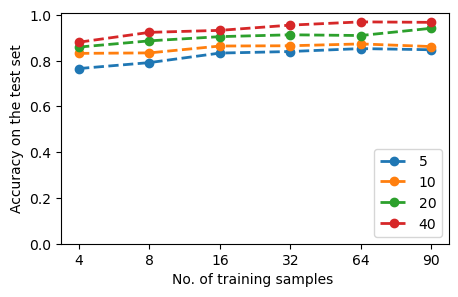

In [25]:
df = pd.read_csv('Effect_of_window_length.csv')
# Plot the line plot
fig, ax = plt.subplots(figsize=(5,3))

for row in range(len(df)):
    ax.plot(df.iloc[row,1:], label=str(df.iloc[row,0]), marker='o',linestyle='--',linewidth=2)

# Add labels and title
ax.set_xlabel('No. of training samples ')
ax.set_ylabel('Accuracy on the test set')
# ax.set_title('Line Plot of Dataset Size vs. Win Length')
ax.legend(loc='lower right')
ax.set_ylim([0,1.01])

# Display the plot
plt.show()

# Effects of various deep learning algorithms (win_length = 10)

In [26]:
# Another helper function to choose diffrent DL algorithm
def select_DL_Model(InputFeature,Target,last_layer_activn,loss_fn,model):

    if model=='lstm':
        # Define input layer
        input_layer = Input(shape=(InputFeature.shape[1],InputFeature.shape[2]))
        # Define LSTM layers with batch normalization in between
        lstm1 = LSTM(32, return_sequences=False)(input_layer)#Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=L1(0.01)))(input_layer)
        # Define hidden layer with batch normalization
        hidden_layer = Dense(units=64, activation='relu',kernel_regularizer=L1(0.01))(lstm1)
        # Define output layer with sigmoid activation function for binary classification
        outputs = Dense(Target.shape[1], activation=last_layer_activn)(hidden_layer)
        # Define the model
        nn_model = Model(inputs=input_layer, outputs=outputs)

        
    else:
        # Define input layer
        input_layer = Input(shape=(InputFeature.shape[1],InputFeature.shape[2]))
        # Convolutional layers
        cnn1 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same')(input_layer)
        cnn1  = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same')(cnn1)
        flat = Flatten()(cnn1)
        # Define hidden layer with batch normalization
        hidden_layer = Dense(units=64, activation='relu')(flat)
        # Define output layer with sigmoid activation function for binary classification
        outputs = Dense(Target.shape[1], activation=last_layer_activn)(hidden_layer)
        # Define the model
        nn_model = Model(inputs=input_layer, outputs=outputs)
        

    # Compile the model with binary cross-entropy loss function and Adam optimizer
    nn_model.compile(loss=loss_fn, optimizer='adam', metrics=['accuracy'])

    
    return nn_model

In [35]:
def EffectOfDLModel(model,w):


    # Import the data
    data = pd.read_csv(".\Electrolyzer_faults.csv")
    # Use sliding window to segment the entire data into small portions
    X,Y,Z = sliding_window(data, window_size=w, stride=1)

    ohe = OneHotEncoder(sparse=False)
    Y_ohe = ohe.fit_transform(Y.reshape(-1,1))
    # Split data into train and test
    x_train, x_test, z_train, z_test = train_test_split(X, Z, test_size=0.2)
    # Normalize the data to range -1,1
    sc= StandardScaler()
    x_train_sc=sc.fit_transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
    x_test_sc=sc.transform(x_test.reshape(-1,x_test.shape[2])).reshape(x_test.shape)
    # Pretraining of the DL model using psuedo labels
    dl_model = select_DL_Model(x_train_sc, z_train,last_layer_activn='sigmoid',loss_fn='binary_crossentropy',model=model)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # Train the model with 20 epochs and batch size of 32, using the early stopping callback
    dl_model.fit(x_train_sc, z_train, epochs=200, batch_size=256, validation_data=(x_test_sc, z_test), callbacks=[early_stop],verbose=0)

    set_of_samples = [4,8,16,32,64,90]
    # set_of_samples = [x * 9 for x in set_of_samples]
    
    F1_score_ft=[]
    for samples in set_of_samples:
        # again split it into train and test set to evaluate the RandomForest model
        x_train,y_train,z_train = resample(X,Y,Z,samples)
        x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
        y_train = ohe.transform(y_train.reshape(-1,1))

        # Fine tune model
        X_sc = sc.transform(X.reshape(-1,X.shape[2])).reshape(X.shape)
        fine_tuned_model,_,_ = FineTunedModel(dl_model,x_train,y_train,X_sc,Y_ohe)

        x_train,y_train,z_train = resample(X,Y,Z,50)
        x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
        
        y_pred = fine_tuned_model.predict(x_train)
        y_pred = ohe.inverse_transform(y_pred)
        y_pred = Cascade_Hybrid_FDI(z_train,y_pred)
        f1 = f1_score(y_train, y_pred, average='macro')
        
        F1_score_ft.append(f1)

    print(f"The DL model {model} :")
    print(F1_score_ft)
    return np.array(F1_score_ft)
    

In [36]:
DL_models = ["1D-CNN","LSTM"]


score_dl_model=[]

for m in DL_models:
    print(f"Experiment for  {m}")
    print("#"*40)
    score_dl_model.append(EffectOfDLModel(m,w=10))


# Create a dataframe from the arrays
df = pd.DataFrame(score_dl_model)

# Rename the columns
df.index = np.array(DL_models)
df.columns = [4,8,16,32,64,90]
# Save the Experiments in a csv file
df.to_csv('Effect_of_DL_model.csv', index=True, index_label='Dl_model')

Experiment for  1D-CNN
########################################
16/16 [==============================] - 0s 2ms/step
The DL model 1D-CNN :
[0.8392059718070932, 0.8599606619029313, 0.8890809160822183, 0.895373340742917, 0.8366350888502565, 0.8992720709554163]
Experiment for  LSTM
########################################
16/16 [==============================] - 0s 2ms/step
The DL model LSTM :
[0.8685403405562637, 0.8478522226671137, 0.8143361669385317, 0.8496303875617965, 0.8846839167455952, 0.8844233984250648]


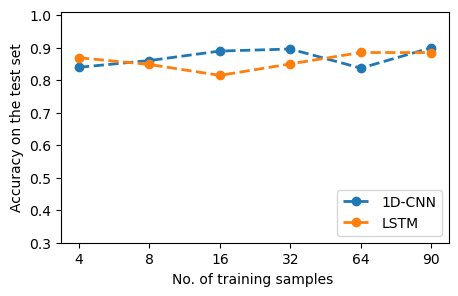

In [37]:
df = pd.read_csv('Effect_of_DL_model.csv')
# Plot the line plot
fig, ax = plt.subplots(figsize=(5,3))

for row in range(len(df)):
    ax.plot(df.iloc[row,1:], label=str(df.iloc[row,0]), marker='o',linestyle='--',linewidth=2)

# Add labels and title
ax.set_xlabel('No. of training samples ')
ax.set_ylabel('Accuracy on the test set')
# ax.set_title('Line Plot of Dataset Size vs. Win Length')
ax.legend(loc='lower right')
ax.set_ylim([0.3,1.01])

# Display the plot
plt.show()

# Effect of raw_sensor data, raw_sensor + SSL, residuals, residuals+SSL     (LSTM,win_length=20)

### Helper function for SSL and Supervised

In [6]:
def SSL(data,w):
    X,Y,Z = sliding_window(data, window_size=w, stride=1)
    ohe = OneHotEncoder(sparse=False)
    Y_ohe = ohe.fit_transform(Y.reshape(-1,1))

    # Normalize the data to range -1,1
    sc= StandardScaler()
    X_sc=sc.fit_transform(X.reshape(-1,X.shape[2])).reshape(X.shape)
    # Split data into train and test
    x_train, x_test, z_train, z_test = train_test_split(X_sc, Z, test_size=0.2)
    # Pretraining of the DL model using psuedo labels
    dl_model = DeepLearningModel(x_train, z_train,last_layer_activation='sigmoid',loss_fn='binary_crossentropy')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # Train the model with 20 epochs and batch size of 32, using the early stopping callback
    dl_model.fit(x_train, z_train, epochs=200, batch_size=128, validation_data=(x_test, z_test), callbacks=[early_stop],verbose=0)

    set_of_samples = [4,8,16,32,64,90]
    # set_of_samples = [x * 9 for x in set_of_samples]
    
    F1_score_ft=[]
    for samples in set_of_samples:
        # again split it into train and test set to evaluate the RandomForest model
        x_train,y_train,z_train = resample(X_sc,Y,Z,samples)
        y_train = ohe.transform(y_train.reshape(-1,1))

        # Fine tune model
        fine_tuned_model,_,_ = FineTunedModel(dl_model,x_train,y_train,X_sc,Y_ohe)

        x_train,y_train,z_train = resample(X_sc,Y,Z,50)
        
        y_pred = fine_tuned_model.predict(x_train)
        y_pred = ohe.inverse_transform(y_pred)
        y_pred = Cascade_Hybrid_FDI(z_train,y_pred)
        f1 = f1_score(y_train, y_pred, average='macro')
        
        F1_score_ft.append(f1)

    print(f"The SSL :")
    print(F1_score_ft)
    return np.array(F1_score_ft)

def supervised_training(data,w):
    X,Y,Z = sliding_window(data, window_size=w, stride=1)
    sc= StandardScaler()
    X_sc=sc.fit_transform(X.reshape(-1,X.shape[2])).reshape(X.shape)
    ohe = OneHotEncoder(sparse=False)
    Y_ohe = ohe.fit_transform(Y.reshape(-1,1))

    set_of_samples = [4,8,16,32,64,90]

    score_lstm=[]
    for samples in set_of_samples:
        # Split data ito train and test
        x_train,y_train,z_train = resample(X_sc,Y,Z,samples)
        y_train = ohe.transform(y_train.reshape(-1,1))
        # Pretraining of the DL model using psuedo labels
        supervised_LSTM = DeepLearningModel(X_sc, Y_ohe,last_layer_activation='softmax',loss_fn='categorical_crossentropy')
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        # Train the model with 20 epochs and batch size of 32, using the early stopping callback
        supervised_LSTM.fit(x_train, y_train, epochs=200, batch_size=int(len(x_train)*0.2), validation_data=(X_sc[::50],Y_ohe[::50]), callbacks=[early_stop],verbose=0)

        x_train,y_train,z_train = resample(X,Y,Z,50)
        x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
        
        y_pred = supervised_LSTM.predict(x_train)
        y_pred = ohe.inverse_transform(y_pred)
        f1 = f1_score(y_train, y_pred, average='macro')


        score_lstm.append(f1)
    print(score_lstm)
    return np.array(score_lstm)


Training Using Residual Data
##############################
residual + SSL
The SSL :
[0.8466571801949778, 0.8884183194134035, 0.8903407043849562, 0.8879171079208646, 0.9031004271700033, 0.8916732010317503]
residual + SL
[0.6635169755511586, 0.7797326794726315, 0.8380364055317495, 0.8815651946584054, 0.8827937227617706, 0.899795051968965]
############################################################
Training Using Raw Sensor Data
##############################
sensor + SSL
The SSL :
[0.6643197496093982, 0.731231641209342, 0.7981218783468182, 0.8390933185653132, 0.8278217963017889, 0.845648746476358]
sensor + SL
[0.4101731728170189, 0.5198793227511451, 0.7136356721306282, 0.7221966358367545, 0.8665548456462465, 0.6803648357906105]
Training Using Residual Data
##############################
residual + SSL
The SSL :
[0.858081452806055, 0.872951066862999, 0.8919991757936361, 0.8935499902688526, 0.897915514670218, 0.8991365901606487]
residual + SL
[0.6709690736592744, 0.7727350563376921, 0.84

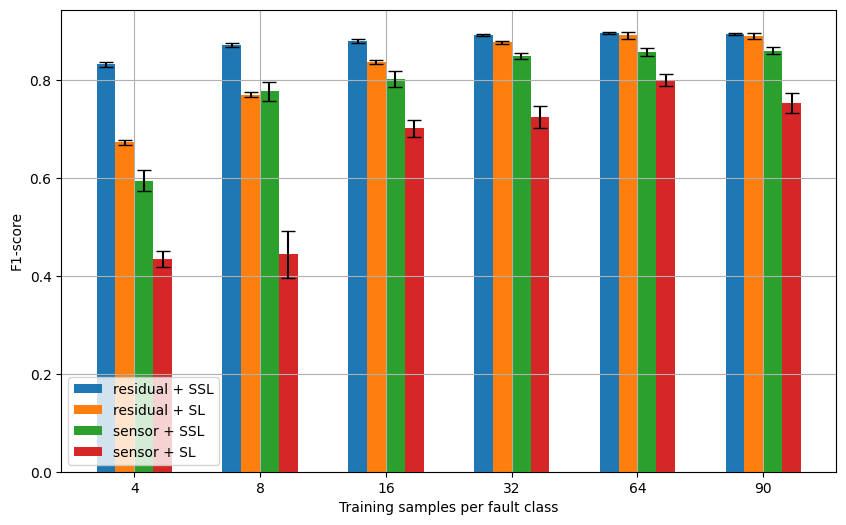

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the list of window lengths
set_of_samples = [4,8,16,32,64,90]

# Define the number of repetitions
num_repetitions = 10
w_len=10

# Initialize empty lists to store the results for different models
arr_ssl_results = []
arr_sl_results = []
sns_ssl_results = []
sns_sl_results = []

# Repeat the experiment 5 times
for _ in range(num_repetitions):
    print('Training Using Residual Data')
    print("#" * 30)

    residual_data = pd.read_csv('Electrolyzer_faults.csv')
    print('residual + SSL')
    arr_ssl = SSL(residual_data, w=w_len)
    arr_ssl_results.append(arr_ssl)
    print('residual + SL')
    arr_sl = supervised_training(residual_data, w=w_len)
    arr_sl_results.append(arr_sl)

    print("##" * 30)

    print('Training Using Raw Sensor Data')
    print("#" * 30)
    sensor_data = pd.read_csv('sensor_data.csv')
    print('sensor + SSL')
    sns_ssl = SSL(sensor_data, w=w_len)
    sns_ssl_results.append(sns_ssl)
    print('sensor + SL')
    sns_sl = supervised_training(sensor_data, w=w_len)
    sns_sl_results.append(sns_sl)

# Calculate the means and standard errors for each model and window length
arr_ssl_means = np.mean(arr_ssl_results, axis=0)
arr_ssl_errors = np.std(arr_ssl_results, axis=0) / np.sqrt(num_repetitions)
arr_sl_means = np.mean(arr_sl_results, axis=0)
arr_sl_errors = np.std(arr_sl_results, axis=0) / np.sqrt(num_repetitions)
sns_ssl_means = np.mean(sns_ssl_results, axis=0)
sns_ssl_errors = np.std(sns_ssl_results, axis=0) / np.sqrt(num_repetitions)
sns_sl_means = np.mean(sns_sl_results, axis=0)
sns_sl_errors = np.std(sns_sl_results, axis=0) / np.sqrt(num_repetitions)

# Create a bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.15
index = np.arange(len(set_of_samples))

plt.bar(index - 1.5 * bar_width, arr_ssl_means, bar_width, yerr=arr_ssl_errors, capsize=5, label='residual + SSL')
plt.bar(index - 0.5 * bar_width, arr_sl_means, bar_width, yerr=arr_sl_errors, capsize=5, label='residual + SL')
plt.bar(index + 0.5 * bar_width, sns_ssl_means, bar_width, yerr=sns_ssl_errors, capsize=5, label='sensor + SSL')
plt.bar(index + 1.5 * bar_width, sns_sl_means, bar_width, yerr=sns_sl_errors, capsize=5, label='sensor + SL')

plt.xlabel('Training samples per fault class')
plt.ylabel('F1-score')
# plt.title('Comparison of Different Models for Varying Window Lengths')
plt.xticks(index, [str(w) for w in set_of_samples])
plt.legend()
plt.grid(visible=True)

plt.show()


In [8]:

# Create a dictionary to store the results
results_dict = {
    'No training samples': np.tile(set_of_samples, 4),
    'Model': (['residual + SSL'] * len(set_of_samples) + ['residual + SL'] * len(set_of_samples) +
             ['sensor + SSL'] * len(set_of_samples) + ['sensor + SL'] * len(set_of_samples)) ,
    'Mean F1 score': np.concatenate([arr_ssl_means, arr_sl_means, sns_ssl_means, sns_sl_means]),
    'Error': np.concatenate([arr_ssl_errors, arr_sl_errors, sns_ssl_errors, sns_sl_errors])
}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

# Save the DataFrame to a CSV file
results_df.to_csv('experiment_results.csv', index=False)


# 4. Quantity of data in Pre-training

In [9]:

def Effect_of_pretraining_data(pre_train_samples):


    # Import the data
    data = pd.read_csv(".\Electrolyzer_faults.csv")
    # Use sliding window to segment the entire data into small portions
    X,Y,Z = sliding_window(data, window_size=10, stride=1)

    ohe = OneHotEncoder(sparse=False)
    Y_ohe = ohe.fit_transform(Y.reshape(-1,1))
    # Split data into train and test
    x_train,_,z_train = Resample(X,Y,Z,pre_train_samples)
    x_test,_,z_test = Resample(X,Y,Z,50)

    # Normalize the data to range -1,1
    sc= StandardScaler()
    x_train_sc=sc.fit_transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
    x_test_sc=sc.transform(x_test.reshape(-1,x_test.shape[2])).reshape(x_test.shape)
    # Pretraining of the DL model using psuedo labels
    dl_model = DeepLearningModel(InputFeature=x_train_sc, Target=z_train, last_layer_activation='sigmoid', loss_fn='binary_crossentropy')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # Train the model with 20 epochs and batch size of 32, using the early stopping callback
    dl_model.fit(x_train_sc, z_train, epochs=200, batch_size=int(len(x_train)*0.1), validation_data=(x_test_sc, z_test), callbacks=[early_stop],verbose=0)

   

    # again split it into train and test set to evaluate the RandomForest model
    x_train,y_train,z_train = Resample(X,Y,Z,8)
    x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
    y_train = ohe.transform(y_train.reshape(-1,1))

    # Fine tune model
    X_sc = sc.transform(X.reshape(-1,X.shape[2])).reshape(X.shape)
    fine_tuned_model,_,_ = FineTunedModel(dl_model,x_train,y_train,X_sc,Y_ohe)

    x_train,y_train,z_train = Resample(X,Y,Z,50)
    x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
    
    y_pred = fine_tuned_model.predict(x_train)
    y_pred = ohe.inverse_transform(y_pred)
    y_pred = Cascade_Hybrid_FDI(z_train,y_pred)
    f1 = f1_score(y_train, y_pred, average='macro')

    print(f"pre_train_samples {pre_train_samples} : F1 score is {f1}")

    return f1
    

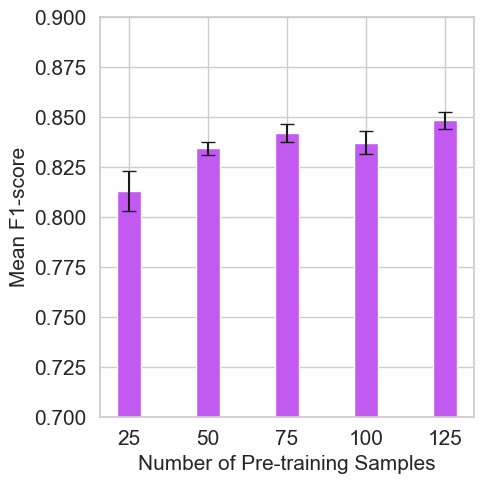

[(0.8131736672147296, 0.009883701349002443), (0.8344850903160441, 0.0030971768859007005), (0.8420401695417841, 0.004513946696575406), (0.8372530987913007, 0.0057312051624344605), (0.8485327486788672, 0.00428560989972634)]


In [21]:
# sns.set(style="whitegrid")

# # Number of repetitions for each experiment
# num_repetitions = 5

# # Results list
# results_pts_all = []

# # Pre-training sample sizes
# Pre_Training_Samples = [25, 50, 75, 100, 125]

# # Experiment for different pre-training sample sizes
# for pts in Pre_Training_Samples:
#     f1_scores_pts = []
#     for _ in range(num_repetitions):
#         f1_pts = Effect_of_pretraining_data(pre_train_samples=pts)
#         f1_scores_pts.append(f1_pts)

#     mean_f1_pts = np.mean(f1_scores_pts)
#     std_error_f1_pts = np.std(f1_scores_pts, ddof=1) / np.sqrt(num_repetitions)

#     results_pts_all.append((mean_f1_pts, std_error_f1_pts))

# Plotting the results
bar_width = 0.3
index = np.arange(len(Pre_Training_Samples))

fig, ax = plt.subplots(figsize=(5, 5))

ax.bar(index, [mean_f1 for mean_f1, _ in results_pts_all], bar_width, yerr=[std_error_f1 for _, std_error_f1 in results_pts_all], capsize=5, color='#c25af2')
ax.set_xlabel('Number of Pre-training Samples', fontsize=15)
ax.set_ylabel('Mean F1-score', fontsize=15)
ax.set_xticks(index)
ax.set_xticklabels([str(pts) for pts in Pre_Training_Samples])
ax.tick_params(axis='both', which='major', labelsize=15)
# ax.legend(fontsize=15)
ax.grid(visible=True)
ax.set_ylim([0.7,0.9])
plt.tight_layout()

# Increase DPI and save the figure
plt.savefig('Plots/experiment_results_pretraining_samples.pdf', dpi=300)
plt.show()

print(results_pts_all)

# 5. Effect of cascading

In [35]:
def Effect_of_cascading(num_samples,cascade=True):


    # Import the data
    data = pd.read_csv(".\Electrolyzer_faults.csv")
    # Use sliding window to segment the entire data into small portions
    X,Y,Z = sliding_window(data, window_size=10, stride=1)

    ohe = OneHotEncoder(sparse=False)
    Y_ohe = ohe.fit_transform(Y.reshape(-1,1))
    # Split data into train and test
    x_train,_,z_train = Resample(X,Y,Z,125)
    x_test,_,z_test = Resample(X,Y,Z,50)

    # Normalize the data to range -1,1
    sc= StandardScaler()
    x_train_sc=sc.fit_transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
    x_test_sc=sc.transform(x_test.reshape(-1,x_test.shape[2])).reshape(x_test.shape)
    # Pretraining of the DL model using psuedo labels
    dl_model = DeepLearningModel(InputFeature=x_train_sc, Target=z_train, last_layer_activation='sigmoid', loss_fn='binary_crossentropy')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # Train the model with 20 epochs and batch size of 32, using the early stopping callback
    dl_model.fit(x_train_sc, z_train, epochs=200, batch_size=int(len(x_train)*0.1), validation_data=(x_test_sc, z_test), callbacks=[early_stop],verbose=0)

   

    # again split it into train and test set to evaluate the RandomForest model
    x_train,y_train,z_train = Resample(X,Y,Z,num_samples)
    x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
    y_train = ohe.transform(y_train.reshape(-1,1))

    # Fine tune model
    X_sc = sc.transform(X.reshape(-1,X.shape[2])).reshape(X.shape)
    fine_tuned_model,_,_ = FineTunedModel(dl_model,x_train,y_train,X_sc,Y_ohe)

    x_train,y_train,z_train = Resample(X,Y,Z,50)
    x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
    
    y_pred = fine_tuned_model.predict(x_train)
    y_pred = ohe.inverse_transform(y_pred)
    if cascade:
        y_pred = Cascade_Hybrid_FDI(z_train,y_pred)
    else:
        pass
    
    f1 = f1_score(y_train, y_pred, average='macro')

    print(f"pre_train_samples {num_samples}, cascade is {cascade} : F1 score is {f1}")

    return f1

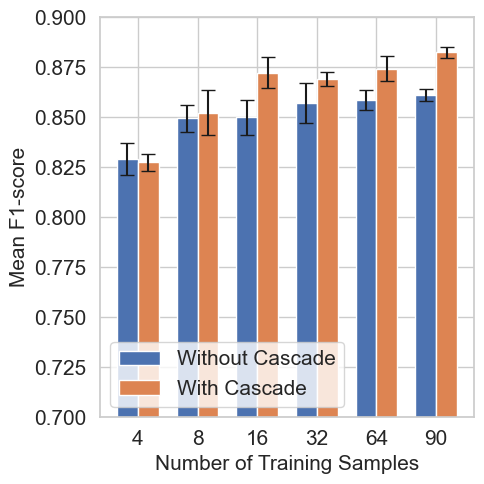

In [39]:
# sns.set(style="whitegrid")

# # Number of repetitions for each experiment
# num_repetitions = 5

# # Results lists
# results_with_cascade_all = []
# results_without_cascade_all = []

# # Pre-training sample sizes
# Training_Samples = [4, 8, 16, 32, 64, 90]

# # Experiment for different pre-training sample sizes
# for pts in Training_Samples:
#     f1_scores_with_cascade = []
#     f1_scores_without_cascade = []

#     for _ in range(num_repetitions):
#         f1_with_cascade = Effect_of_cascading(num_samples=pts, cascade=True)
#         f1_without_cascade = Effect_of_cascading(num_samples=pts, cascade=False)

#         f1_scores_with_cascade.append(f1_with_cascade)
#         f1_scores_without_cascade.append(f1_without_cascade)

#     mean_f1_with_cascade = np.mean(f1_scores_with_cascade)
#     std_error_f1_with_cascade = np.std(f1_scores_with_cascade, ddof=1) / np.sqrt(num_repetitions)
#     results_with_cascade_all.append((mean_f1_with_cascade, std_error_f1_with_cascade))

#     mean_f1_without_cascade = np.mean(f1_scores_without_cascade)
#     std_error_f1_without_cascade = np.std(f1_scores_without_cascade, ddof=1) / np.sqrt(num_repetitions)
#     results_without_cascade_all.append((mean_f1_without_cascade, std_error_f1_without_cascade))

# Plotting the results with and without cascade
bar_width = 0.35
index = np.arange(len(Training_Samples))

fig, ax = plt.subplots(figsize=(5, 5))

ax.bar(index - bar_width/2, [mean_f1 for mean_f1, _ in results_with_cascade_all], bar_width, yerr=[std_error_f1 for _, std_error_f1 in results_with_cascade_all], capsize=5, label='Without Cascade')
ax.bar(index + bar_width/2, [mean_f1 for mean_f1, _ in results_without_cascade_all], bar_width, yerr=[std_error_f1 for _, std_error_f1 in results_without_cascade_all], capsize=5, label='With Cascade')

ax.set_xlabel('Number of Training Samples', fontsize=15)
ax.set_ylabel('Mean F1-score', fontsize=15)
ax.set_xticks(index)
ax.set_xticklabels([str(pts) for pts in Training_Samples])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=15)
ax.grid(visible=True)
ax.set_ylim([0.7,0.9])
plt.tight_layout()

# Increase DPI and save the figure
plt.savefig('Plots/experiment_results_cascading.pdf', dpi=300)
plt.show()


In [37]:
print(results_with_cascade_all)

[(0.8291833892115881, 0.008179952600221037), (0.8496556954214671, 0.006783497753129092), (0.8499957288640682, 0.008575088421833682), (0.8572082957318138, 0.010094304756089318), (0.8587499285508114, 0.004947105588148471), (0.8613824988838399, 0.0029156629687555236)]


In [38]:
print(results_without_cascade_all)

[(0.8274711683820352, 0.004341010233604208), (0.8524547550576218, 0.011031904696127888), (0.8724184270231644, 0.007911966855623538), (0.8693285740462349, 0.0036239582310576414), (0.8744187700094974, 0.006084582636293349), (0.8826785701199125, 0.002709733694539588)]
